In [1]:
import math
import torch
import hess
import matplotlib.pyplot as plt
import numpy as np
from hess.nets import Transformer

In [2]:
nx = 500
train_x = torch.linspace(0, 10, nx).unsqueeze(-1)
train_y = torch.sin(train_x * math.pi) + torch.sin(train_x)

In [3]:
optimus = Transformer(train_x, train_y, n_hidden=2, hidden_size=10,
                     activation=torch.nn.Tanh())

In [4]:
trained_pars = torch.load("../hess/saved-models/toy_regression.pt", map_location="cpu")

In [44]:
trained_pars

OrderedDict([('sequential.0.weight', tensor([[-0.3416],
                      [-0.0795],
                      [-0.0851],
                      [ 0.3641],
                      [ 1.4479],
                      [-0.0801],
                      [-0.2903],
                      [ 3.6203],
                      [-0.2919],
                      [ 0.0798]])),
             ('sequential.2.weight',
              tensor([[-0.1754,  0.6668,  0.7781,  0.1552,  0.2304,  0.7990,  0.2673, -0.3936,
                        0.4077, -0.4575],
                      [-0.2675,  0.6268,  0.8551,  0.3422, -0.3907,  0.7269, -0.8777, -0.0199,
                       -0.6237, -0.4115],
                      [-0.2404, -2.0211, -1.8860,  0.1023, -1.6048, -1.8859, -0.5284, -2.9404,
                       -0.2555,  1.9294],
                      [-0.4646,  2.2174,  2.3839,  0.9101,  2.0839,  2.3737,  1.3752,  1.5239,
                        1.4252, -2.0377],
                      [ 0.5264, -0.9205, -0.9658, -0.7263, 

In [5]:
optimus.net.load_state_dict(trained_pars)

<All keys matched successfully>

In [6]:
hessian = torch.load("../hess/saved-models/toy_hessian.pt", map_location="cpu")

In [7]:
orig_pred = optimus(train_x)

In [8]:
e_val, e_vec = np.linalg.eig(hessian)
idx = e_val.argsort()[::-1]   
e_val = torch.FloatTensor(e_val[idx].real)
e_vec = torch.FloatTensor(e_vec[:,idx].real)

### Perturb in largest e-vec basis

In [9]:
import hess.utils as utils

In [40]:
top_vecs = e_vec[:, 0:3]

In [41]:
n_pert = 10
scale = 0.05
pert_preds = torch.zeros(nx, n_pert)

In [42]:
for jj in range(10):
    wghts = torch.randn(3)*0.01
    perturb = top_vecs.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)
    print(perturb)
    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
        
    pert_preds[:, jj] = optimus(train_x).squeeze()
    
    optimus.net.load_state_dict(trained_pars)

tensor([[-1.9491e-02, -1.6831e-02, -5.0607e-03,  1.7330e-02,  3.5521e-04,
         -1.3036e-02, -9.6762e-03, -7.4662e-06, -8.9846e-03,  1.4084e-02,
         -9.8659e-04, -2.7502e-04, -2.9460e-04,  1.0286e-03,  1.6335e-03,
         -2.7745e-04, -8.8103e-04,  1.6502e-03, -8.8461e-04,  2.7624e-04,
         -1.5922e-03, -7.2788e-04, -8.4355e-04,  1.5795e-03,  1.1036e-03,
         -7.6130e-04, -1.6030e-03,  1.0962e-03, -1.6034e-03,  7.5194e-04,
         -4.2487e-03, -1.8258e-03, -1.9349e-03,  4.2932e-03,  4.4567e-03,
         -1.8378e-03, -4.0983e-03,  4.4536e-03, -4.1042e-03,  1.8312e-03,
          4.4922e-04,  1.2232e-04,  1.3135e-04, -4.6690e-04, -7.2466e-04,
          1.2345e-04,  4.0347e-04, -7.3804e-04,  4.0503e-04, -1.2289e-04,
          2.1570e-03, -7.6764e-04, -7.8537e-04, -2.4081e-03, -5.8747e-03,
         -7.7334e-04,  1.5240e-03, -6.0306e-03,  1.5455e-03,  7.7168e-04,
         -3.0950e-03, -8.1117e-04, -8.6985e-04,  3.2503e-03,  5.8686e-03,
         -8.1870e-04, -2.7173e-03,  6.

### Perturb in smallest e-vec basis

In [32]:
bot_vecs = e_vec[:, -3:]

In [33]:
n_pert = 10
small_pert_preds = torch.zeros(nx, n_pert)

In [45]:
for jj in range(10):
    wghts = torch.randn(3)
    perturb = bot_vecs.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)
    print(perturb.shape)
    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
    small_pert_preds[:, jj] = optimus(train_x).squeeze()
    
    optimus.net.load_state_dict(trained_pars)

torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])


### Plotting

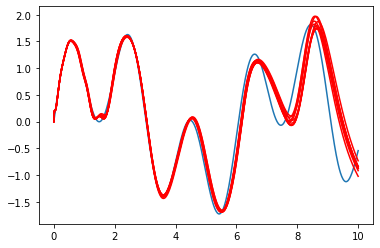

In [35]:
plt.plot(train_x, train_y.detach())
plt.plot(train_x, small_pert_preds.detach(), color="red")

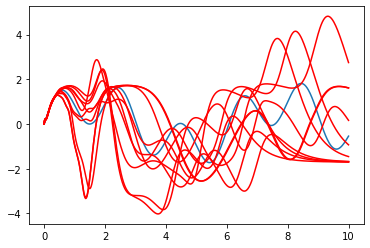

In [36]:
plt.plot(train_x, train_y.detach())
plt.plot(train_x, pert_preds.detach(), color="red")

In [37]:
test = optimus(train_x)

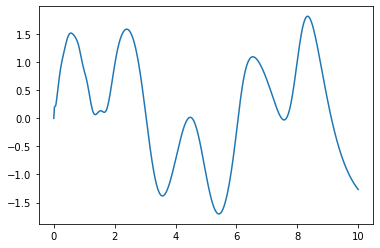

In [38]:
plt.plot(train_x, test.detach())

## Scratch

In [20]:
t1 = torch.randn(100, 1)
t2 = torch.randn(100, 1)

In [21]:
t1.squeeze().dot(t2.squeeze())

tensor(9.1945)

In [22]:
t1.norm()

tensor(10.4111)

In [43]:
out = [p.data for p in optimus.net.parameters()]

ValueError: only one element tensors can be converted to Python scalars